In [47]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf

# Data cleaning and normalization

In [50]:
training_session_folder = 'C:/Users/chiny/cjwen/ITI110/hourly_training'
df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")


In [51]:
df.isnull().sum()      

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

In [52]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])
# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]

,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


In [53]:
df = df.drop([15758, 15759])

In [54]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())


# Create X new columns using past X timestamp data

In [55]:
dataframe = df.loc[:,"avg_energy_per_lclid"]
dataset = dataframe.values
dataset = dataset.astype("float32")

In [56]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [59]:
history = 24
future = 1
reframed = series_to_supervised(dataset, history,future)
reframed.head(3)



,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,...,0.525308,0.539538,0.331769,0.280231,0.256846,0.221692,0.262462,0.359692,0.307286,0.320643
25,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,...,0.539538,0.331769,0.280231,0.256846,0.221692,0.262462,0.359692,0.307286,0.320643,0.410647
26,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,...,0.331769,0.280231,0.256846,0.221692,0.262462,0.359692,0.307286,0.320643,0.410647,0.382167


In [60]:
scaler_label = MinMaxScaler(feature_range=(0, 1))

In [11]:
# Merge the reframed columns with weather and time features

In [61]:
reframed["month"] = df.month.values[history:]
reframed["hour"] = df.hour.values[history:]
reframed["temperature"] = df.temperature.values[history:]
reframed["humidity"] = df.humidity.values[history:]
reframed["windSpeed"] = df.windSpeed.values[history:]
reframed["holiday"] = df.holiday.values[history:]

In [62]:
reframed_tstp = pd.DataFrame()
reframed_tstp["tstp"] = df.tstp.values[history:]

In [63]:
reframed_tstp

,tstp
0,2011-11-24 09:00:00
1,2011-11-24 10:00:00
2,2011-11-24 11:00:00
3,2011-11-24 12:00:00
4,2011-11-24 13:00:00
...,...
19833,2014-02-27 20:00:00
19834,2014-02-27 21:00:00
19835,2014-02-27 22:00:00
19836,2014-02-27 23:00:00


In [64]:
reframed

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-3),var1(t-2),var1(t-1),var1(t),month,hour,temperature,humidity,windSpeed,holiday
24,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,...,0.262462,0.359692,0.307286,0.320643,11,9,10.12,0.95,3.36,0.0
25,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,...,0.359692,0.307286,0.320643,0.410647,11,10,10.99,0.93,3.59,0.0
26,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,...,0.307286,0.320643,0.410647,0.382167,11,11,12.29,0.88,4.35,0.0
27,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,...,0.320643,0.410647,0.382167,0.387818,11,12,12.93,0.81,5.26,0.0
28,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,0.602615,...,0.410647,0.382167,0.387818,0.422920,11,13,12.92,0.78,5.66,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,0.703595,0.646784,0.572335,0.457546,0.389039,0.302443,0.254893,0.236716,0.226965,0.241724,...,0.507056,0.658782,0.722878,0.694360,2,20,5.94,0.76,3.25,0.0
19858,0.646784,0.572335,0.457546,0.389039,0.302443,0.254893,0.236716,0.226965,0.241724,0.304575,...,0.658782,0.722878,0.694360,0.657011,2,21,5.03,0.79,3.06,0.0
19859,0.572335,0.457546,0.389039,0.302443,0.254893,0.236716,0.226965,0.241724,0.304575,0.418228,...,0.722878,0.694360,0.657011,0.587121,2,22,4.10,0.84,3.02,0.0
19860,0.457546,0.389039,0.302443,0.254893,0.236716,0.226965,0.241724,0.304575,0.418228,0.480480,...,0.694360,0.657011,0.587121,0.469473,2,23,3.93,0.85,2.75,0.0


In [65]:
reframed.columns

Index(['var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)', 'month',
       'hour', 'temperature', 'humidity', 'windSpeed', 'holiday'],
      dtype='object')

In [66]:
reframed = reframed.reindex(["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)'],axis=1)

In [67]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19838 entries, 24 to 19861
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        19838 non-null  int64  
 1   hour         19838 non-null  int64  
 2   temperature  19838 non-null  float64
 3   humidity     19838 non-null  float64
 4   windSpeed    19838 non-null  float64
 5   holiday      19838 non-null  float64
 6   var1(t-24)   19838 non-null  float32
 7   var1(t-23)   19838 non-null  float32
 8   var1(t-22)   19838 non-null  float32
 9   var1(t-21)   19838 non-null  float32
 10  var1(t-20)   19838 non-null  float32
 11  var1(t-19)   19838 non-null  float32
 12  var1(t-18)   19838 non-null  float32
 13  var1(t-17)   19838 non-null  float32
 14  var1(t-16)   19838 non-null  float32
 15  var1(t-15)   19838 non-null  float32
 16  var1(t-14)   19838 non-null  float32
 17  var1(t-13)   19838 non-null  float32
 18  var1(t-12)   19838 non-null  float32
 19  var1(t-1

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))

reframed[["month","hour","temperature","humidity","windSpeed","holiday"]] = scaler.fit_transform(reframed[["month","hour","temperature","humidity","windSpeed","holiday"]])

# Split data

In [74]:
train_rows = int(0.8*len(reframed))
train = reframed[:train_rows]
test = reframed[train_rows:]

print("dataset no. of rows: ", len(reframed))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

dataset no. of rows:  19838
train dataset no. of rows:  15870
test dataset no. of rows:  3968


In [75]:
train_tstp = reframed_tstp[:train_rows]
test_tstp = reframed_tstp[train_rows:]

print("dataset no. of rows: ", len(reframed_tstp))
print("train_tstp dataset no. of rows: ", len(train_tstp))
print("test_tstp dataset no. of rows: ", len(test_tstp))

dataset no. of rows:  19838
train_tstp dataset no. of rows:  15870
test_tstp dataset no. of rows:  3968


In [76]:
test.tail()

,month,hour,temperature,humidity,windSpeed,holiday,var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
19857,0.090909,0.869565,0.304416,0.688312,0.217480,0.0,0.703595,0.646784,0.572335,0.457546,...,0.395175,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360
19858,0.090909,0.913043,0.280494,0.727273,0.204607,0.0,0.646784,0.572335,0.457546,0.389039,...,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011
19859,0.090909,0.956522,0.256046,0.792208,0.201897,0.0,0.572335,0.457546,0.389039,0.302443,...,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121
19860,0.090909,1.000000,0.251577,0.805195,0.183604,0.0,0.457546,0.389039,0.302443,0.254893,...,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473
19861,0.090909,0.000000,0.248423,0.805195,0.168699,0.0,0.389039,0.302443,0.254893,0.236716,...,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473,0.209844


In [77]:
features = ["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']
label = ["var1(t)"]

In [78]:
train_X = np.array(train[features])
train_y = np.array(train[label])
test_X = np.array(test[features])
test_y = np.array(test[label])

In [79]:
# train_X_norm = scaler_features.fit_transform(train_X)
# test_X_norm = scaler_features.fit_transform(test_X)
# train_y_norm = scaler_label.fit_transform(train_y)
# test_y_norm = scaler_label.fit_transform(test_y)


In [80]:
train_X.shape

(15870, 30)

In [81]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(15870, 1, 30) (15870, 1) (3968, 1, 30) (3968, 1)


In [82]:
def performance_visualization(model, train_input, train_actual, test_input, test_actual, start_row=0, end_row=100):
    train_result = pd.DataFrame()
    train_pred = model.predict(train_input)
    train_mae = mae(train_actual, train_pred)
    train_mape = mape(train_actual,train_pred)
    train_rmse = math.sqrt(mean_squared_error(train_actual,train_pred))
    train_result["tstp"] = train_tstp["tstp"]
    train_result["tstp"] = pd.to_datetime(train_result["tstp"])
    train_result["train_pred"]= train_pred
    train_result["train_actual"]= train_actual
    print(f"Train MAE: {train_mae}")
    print(f"Train MAPE: {train_mape}")
    print(f"Train RMSE: {train_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "train_actual", label='actual', data = train_result[start_row:end_row])
    plt.plot("tstp", "train_pred", label='prediction', data = train_result[start_row:end_row])

    # plt.plot(train_pred[start_row:end_row], label='prediction', x = "tstp")
    plt.title("Train Actual vs prediction")
    plt.legend()
    plt.show()
              
              
    test_result = pd.DataFrame()
    test_pred = model.predict(test_input)
    test_mae = mae(test_actual, test_pred)
    test_mape = mape(test_actual,test_pred)
    test_rmse = math.sqrt(mean_squared_error(test_actual,test_pred))
    test_result["tstp"] = test_tstp["tstp"]
    test_result["tstp"] = pd.to_datetime(test_result["tstp"])
    test_result["test_pred"]= test_pred
    test_result["test_actual"]= test_actual
    print(f"Test MAE: {test_mae}")
    print(f"Test MAPE: {test_mape}")
    print(f"Test RMSE: {test_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "test_actual", label='actual', data = test_result[start_row:end_row])
    plt.plot("tstp", "test_pred", label='prediction', data = test_result[start_row:end_row])
    plt.title("Test Actual vs prediction")
    plt.legend()
    plt.show()          
    
    return train_result, test_result

# Run 12 - 2 layers LSTM 96 neurons

In [85]:
model12 = Sequential()
    
model12.add(LSTM(units = 96, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model12.add(LSTM(units = 96))
model12.add(Dense(1))
    
model12.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanAbsoluteError()])

In [86]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_12/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

Epoch 1/500

496/496 [==============================] - 5s 5ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 2/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181
Epoch 3/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 4/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 5/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 6/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161
Epoch 7/5

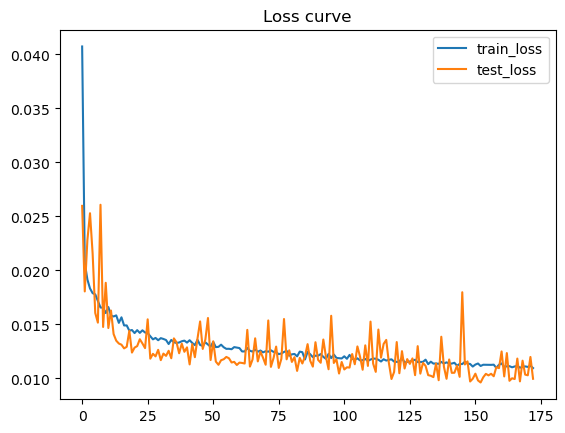

In [87]:
history = model12.fit(train_X, train_y, epochs=500, validation_data = (test_X, test_y), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

496/496 [==============================] - 1s 957us/step
Train MAE: 0.010325989685952663
Train MAPE: 0.023427050560712814
Train RMSE: 0.015375224757871696


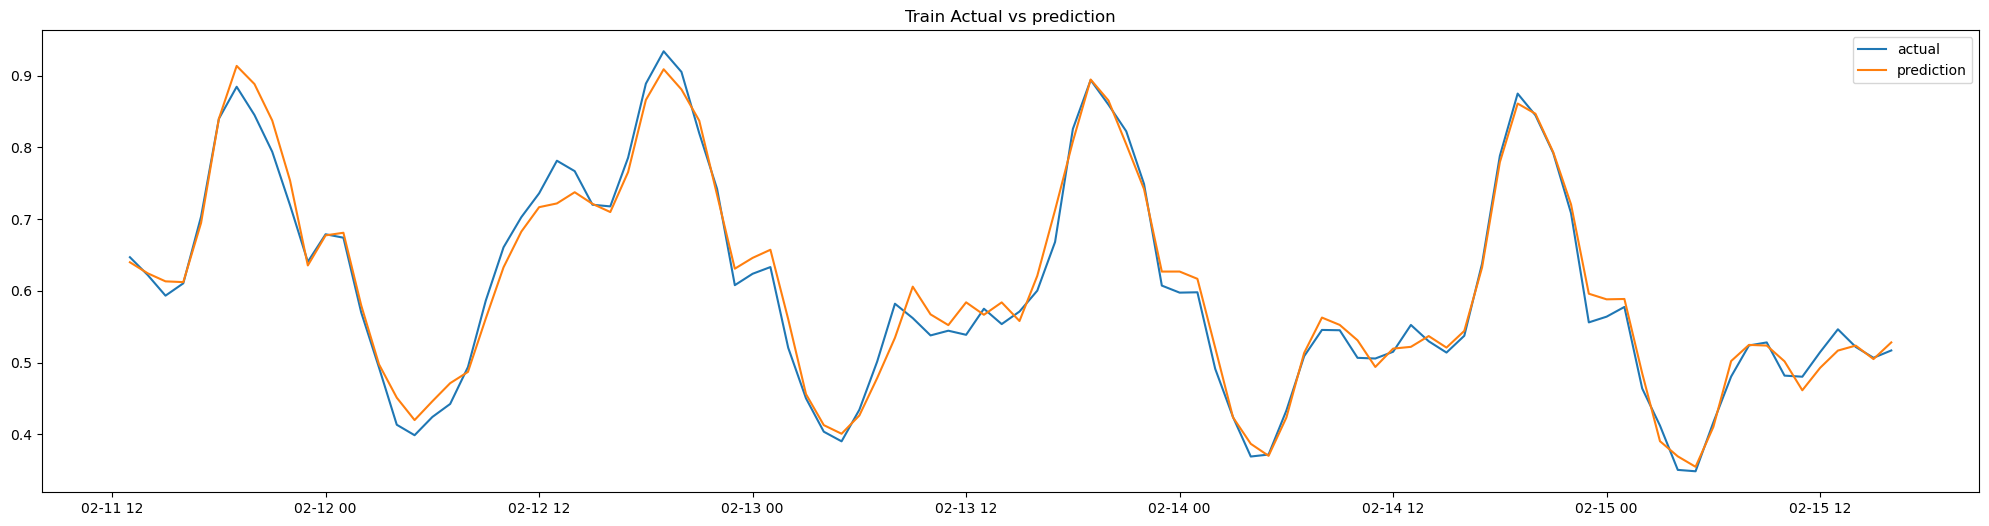

124/124 [==============================] - 0s 1ms/step
Test MAE: 0.009964686818420887
Test MAPE: 0.022328831255435944
Test RMSE: 0.013944217168208812


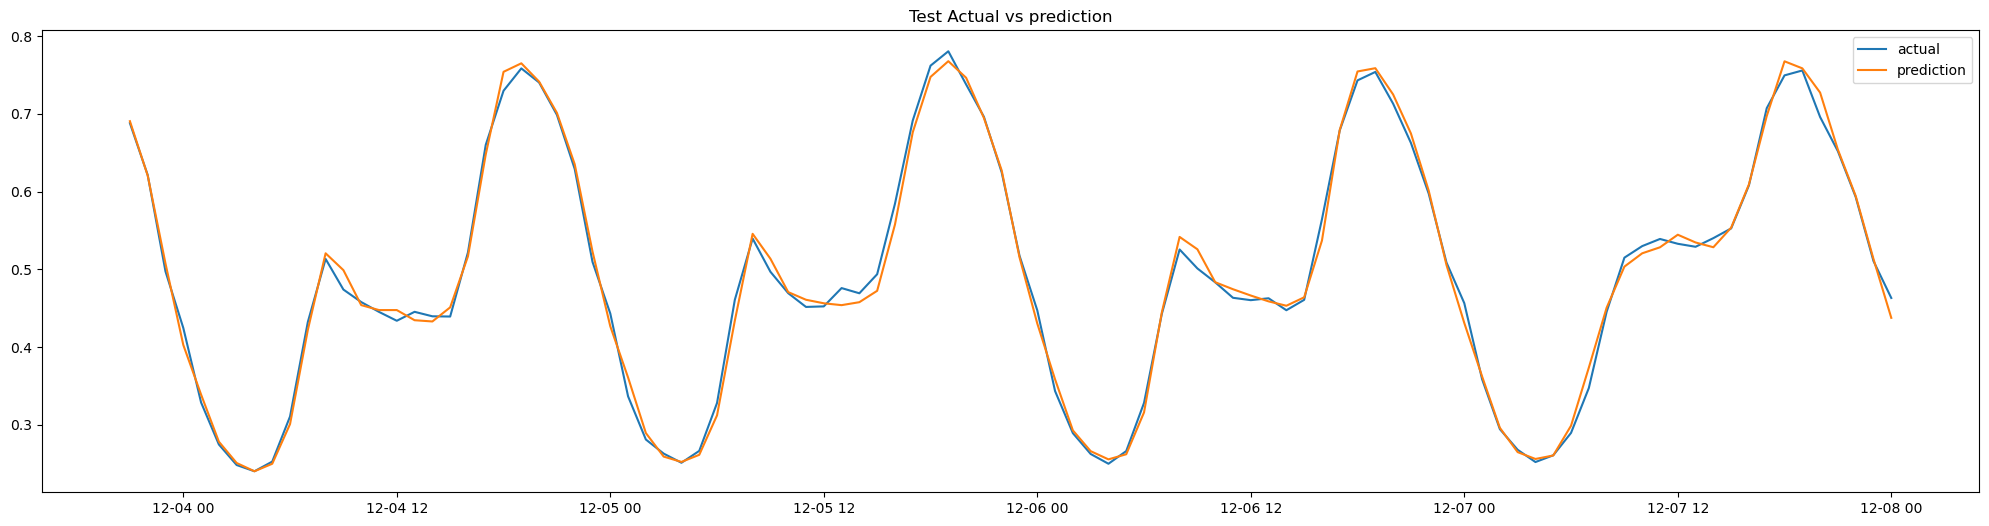

In [88]:
train_result, test_result = performance_visualization(model12, train_X, train_y, test_X, test_y, 1900, 2000)

In [89]:
test_result["delta"] = abs(test_result["test_pred"] - test_result["test_actual"])
test_result["percentage_delta"] = (abs(test_result["test_pred"] - test_result["test_actual"]))/abs(test_result["test_actual"])
test_result["hour"] = test_result["tstp"].dt.hour.astype('str')
test_result["month"] = test_result["tstp"].dt.month.astype('str')
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968 entries, 15870 to 19837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tstp              3968 non-null   datetime64[ns]
 1   test_pred         3968 non-null   float32       
 2   test_actual       3968 non-null   float32       
 3   delta             3968 non-null   float32       
 4   percentage_delta  3968 non-null   float32       
 5   hour              3968 non-null   object        
 6   month             3968 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(2)
memory usage: 155.1+ KB


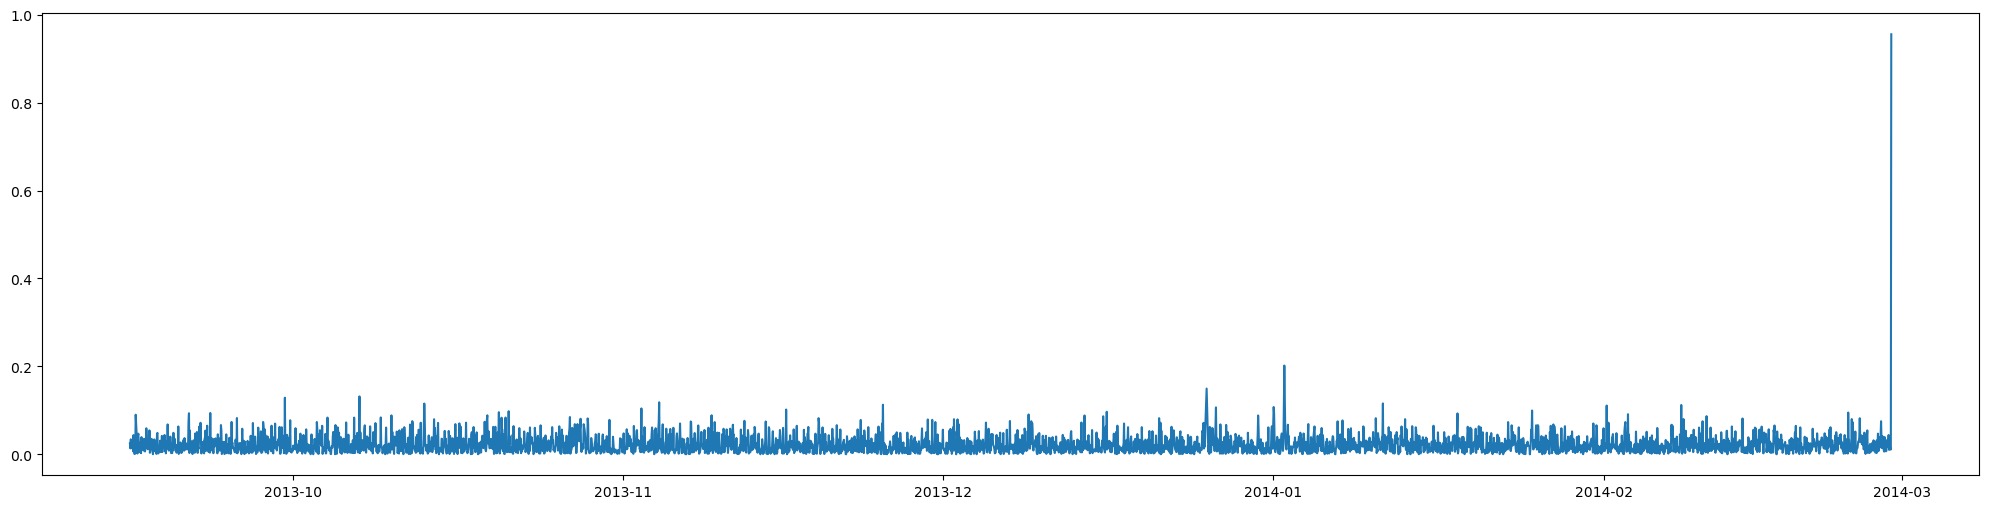

In [90]:
import seaborn as sns
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot("tstp", "percentage_delta", data=test_result)

In [91]:
percentage_delta_by_hour = pd.DataFrame()
percentage_delta_by_hour = test_result["percentage_delta"].groupby(test_result["hour"]).describe()
percentage_delta_by_hour.sort_values(by="50%")

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
3,165.0,0.011372,0.008216,0.000585,0.004886,0.010421,0.014898,0.057944
22,166.0,0.014318,0.011231,0.000056,0.005154,0.011455,0.021619,0.063343
19,166.0,0.016165,0.015356,0.000618,0.005787,0.011508,0.022451,0.107662
4,165.0,0.015042,0.011537,0.000103,0.005805,0.012811,0.023105,0.050583
10,165.0,0.017750,0.015047,0.000238,0.005708,0.013624,0.025569,0.071895
21,166.0,0.016923,0.014023,0.000028,0.005004,0.013921,0.024799,0.064230
5,165.0,0.019201,0.016931,0.000126,0.006750,0.014002,0.025659,0.079268
2,165.0,0.018115,0.015915,0.000003,0.006155,0.015190,0.025673,0.128560
20,166.0,0.018641,0.015088,0.000030,0.006806,0.015398,0.025990,0.068456


In [92]:
percentage_delta_styled=percentage_delta_by_hour.drop(columns = "count", axis=1).style.background_gradient()
percentage_delta_styled

,mean,std,min,25%,50%,75%,max
hour,,,,,,,
0,0.036336,0.074929,0.000475,0.013356,0.028119,0.043768,0.955569
1,0.036717,0.025545,0.000572,0.017565,0.035235,0.050826,0.201865
10,0.017750,0.015047,0.000238,0.005708,0.013624,0.025569,0.071895
11,0.023084,0.016933,0.000166,0.009877,0.019838,0.032703,0.071966
12,0.019274,0.016250,0.000602,0.006801,0.015797,0.026249,0.080110
13,0.019449,0.014219,0.000047,0.007955,0.016621,0.028780,0.061239
14,0.019477,0.017069,0.000099,0.006252,0.016153,0.027109,0.088297
15,0.021731,0.017613,0.000071,0.009441,0.018548,0.030323,0.106673
16,0.023135,0.017952,0.000163,0.009192,0.020126,0.032725,0.089667


In [162]:
import seaborn as sns

# Run 13 - CNN LSTM - 7 days shifted

In [95]:
x_train_2 = train_X.reshape((train_X.shape[0], train_X.shape[2], 1))
x_test_2 = test_X.reshape((test_X.shape[0], test_X.shape[2], 1))
print(x_train_2.shape, train_y.shape, x_test_2.shape, test_y.shape)

(15870, 30, 1) (15870, 1) (3968, 30, 1) (3968, 1)


In [98]:
def get_model_cnn_lstm():
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train_2.shape[1], x_train_2.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=1, activation='relu'))
    model.add(LSTM(160, return_sequences=True, activation='relu'))
    model.add(LSTM(512, return_sequences=False, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
    return model

model13 = get_model_cnn_lstm()
model13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 6)             12        
                                                                 
 lstm_6 (LSTM)               (None, 30, 160)           106880    
                                                                 
 lstm_7 (LSTM)               (None, 512)               1378304   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1485709 (5.67 MB)
Trainable params: 1485709 (5.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
221/221 - 23s - loss: 0.0841 - mean_absolute_error: 0.0841 - val_loss: 0.1125 - val_mean_absolute_error: 0.1125 - 23s/epoch - 102ms/step
Epoch 2/500
221/221 - 23s - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854 - 23s/epoch - 105ms/step
Epoch 3/500
221/221 - 22s - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0676 - val_mean_absolute_error: 0.0676 - 22s/epoch - 101ms/step
Epoch 4/500
221/221 - 23s - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0713 - val_mean_absolute_error: 0.0713 - 23s/epoch - 104ms/step
Epoch 5/500
221/221 - 23s - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0740 - val_mean_absolute_error: 0.0740 - 23s/epoch - 104ms/step
Epoch 6/500
221/221 - 23s - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0746 - val_mean_absolute_error: 0.0746 - 23s/epoch - 104ms/step
Epoch 7/500
221/221 - 23s - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0704 - val_mean_absol

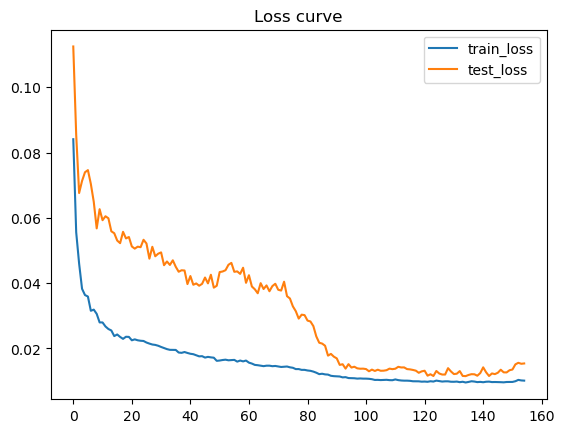

In [99]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_13/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model11.fit(x_train_2, train_y, validation_data = (x_test_2, test_y), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()